# Breast Cancer Classification: Random Forest 🌳🌳

## Setup

In [1]:
from typing import Tuple
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Scikit-Learn
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay,
    recall_score,
    precision_score,
)

In [2]:
DATASET_PATH = "../datasets/breast-cancer.csv"
CMAP = sns.diverging_palette(230, 20, n=24)
RANDOM_SEED = 1992

## Data Loading

Let's start by loading the dataset and explore the data we will work with:

In [3]:
df = pl.read_csv(DATASET_PATH)
df.head()

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
842302,"""M""",17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,null
842517,"""M""",20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902,null
84300903,"""M""",19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758,null
84348301,"""M""",11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,0.09744,0.4956,1.156,3.445,27.23,0.00911,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173,null
84358402,"""M""",20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.01149,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678,null


The dataset contains 33 columns, most of them being float values, one `id` column and the `diagnosis` column that is the target. 
The `id` column is not necessary since it doesn't add relevant information for the predictions. Furthermore, there's an unnamed column at the end of the dataset. Let's analyze its statistics to determine if contains relevant information:

In [4]:
df[""].describe()

statistic,value
str,str
"""count""","""0"""
"""null_count""","""569"""


It contains only null values. Therefore, we can drop the columns `id` and the `unnamed` columns. Now let's see how many null values and how many duplicated rows we have.

In [5]:
df.null_count()

id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,569


We have null values only on the unnamed column at the end.

In [6]:
dups = df.is_duplicated().sum()
print(f"There are {dups} duplicated rows.")

There are 0 duplicated rows.


There's no need to remove duplicated lines since there is none.

## Exploratory Data Analysis

The dataset contains 33 columns: 1 for `id`, 1 for the target `diagnosis` column, 1 in blank, and 30 feature columns. When working with a dataset it is important to validate if there is correlation between its features. A correlation close to 1 means that the features are positively correlated, close to -1 means they are negatively correlated. 

If we have several highly correlated features, it may be a good idea to remove them to reduce the number of features (simpler model), and to improve the speed of training and inference of the model. 

Let's see what is the correlation between the features.

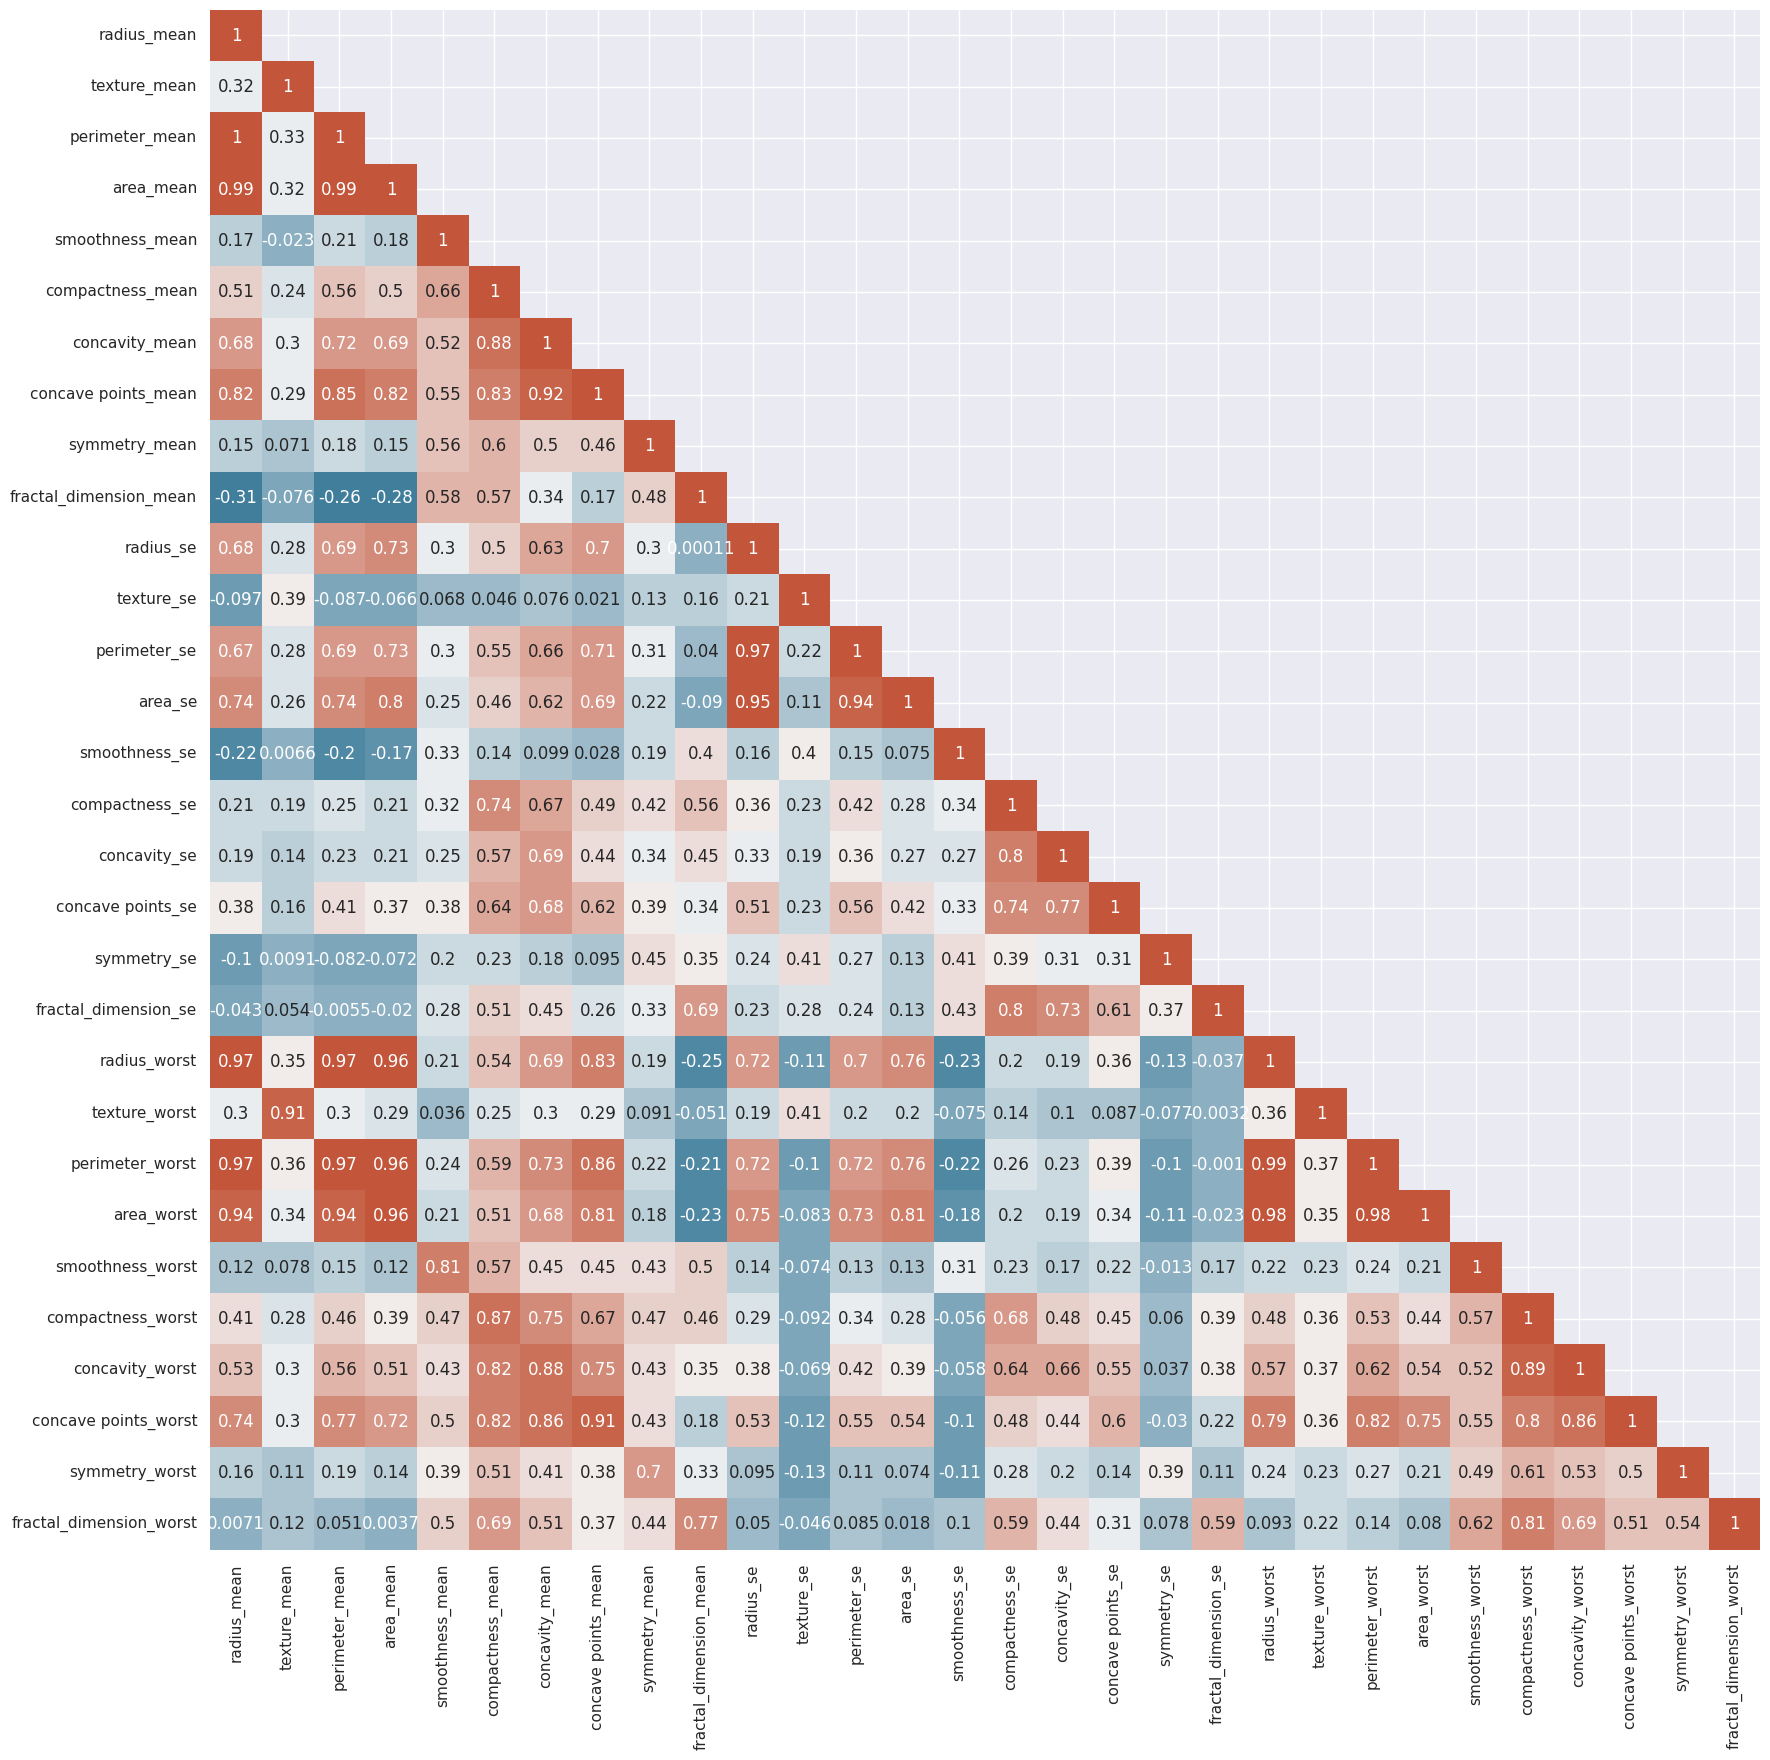

In [7]:
df_feats = df.drop(["id", "", "diagnosis"])
# Mask to remove superior correlation
corr_mask = df_feats.corr().to_numpy() - np.tril(df_feats.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(
    df_feats.to_pandas().corr(), annot=True, cbar=False, mask=corr_mask, cmap=CMAP
)
plt.show()

There are several features with correlation between them. Most of these correlations are linked to the `radius_mean` that is positively correlated with `perimeter_mean` and `area_mean`. The same is for the `_se` features that stands for *standard error* , and for the `_worst` features that are the worst or largest of the cell nuclei on the sample. 

The strategy that I will follow in this case will be removing the `perimeter` and `area` related features. 

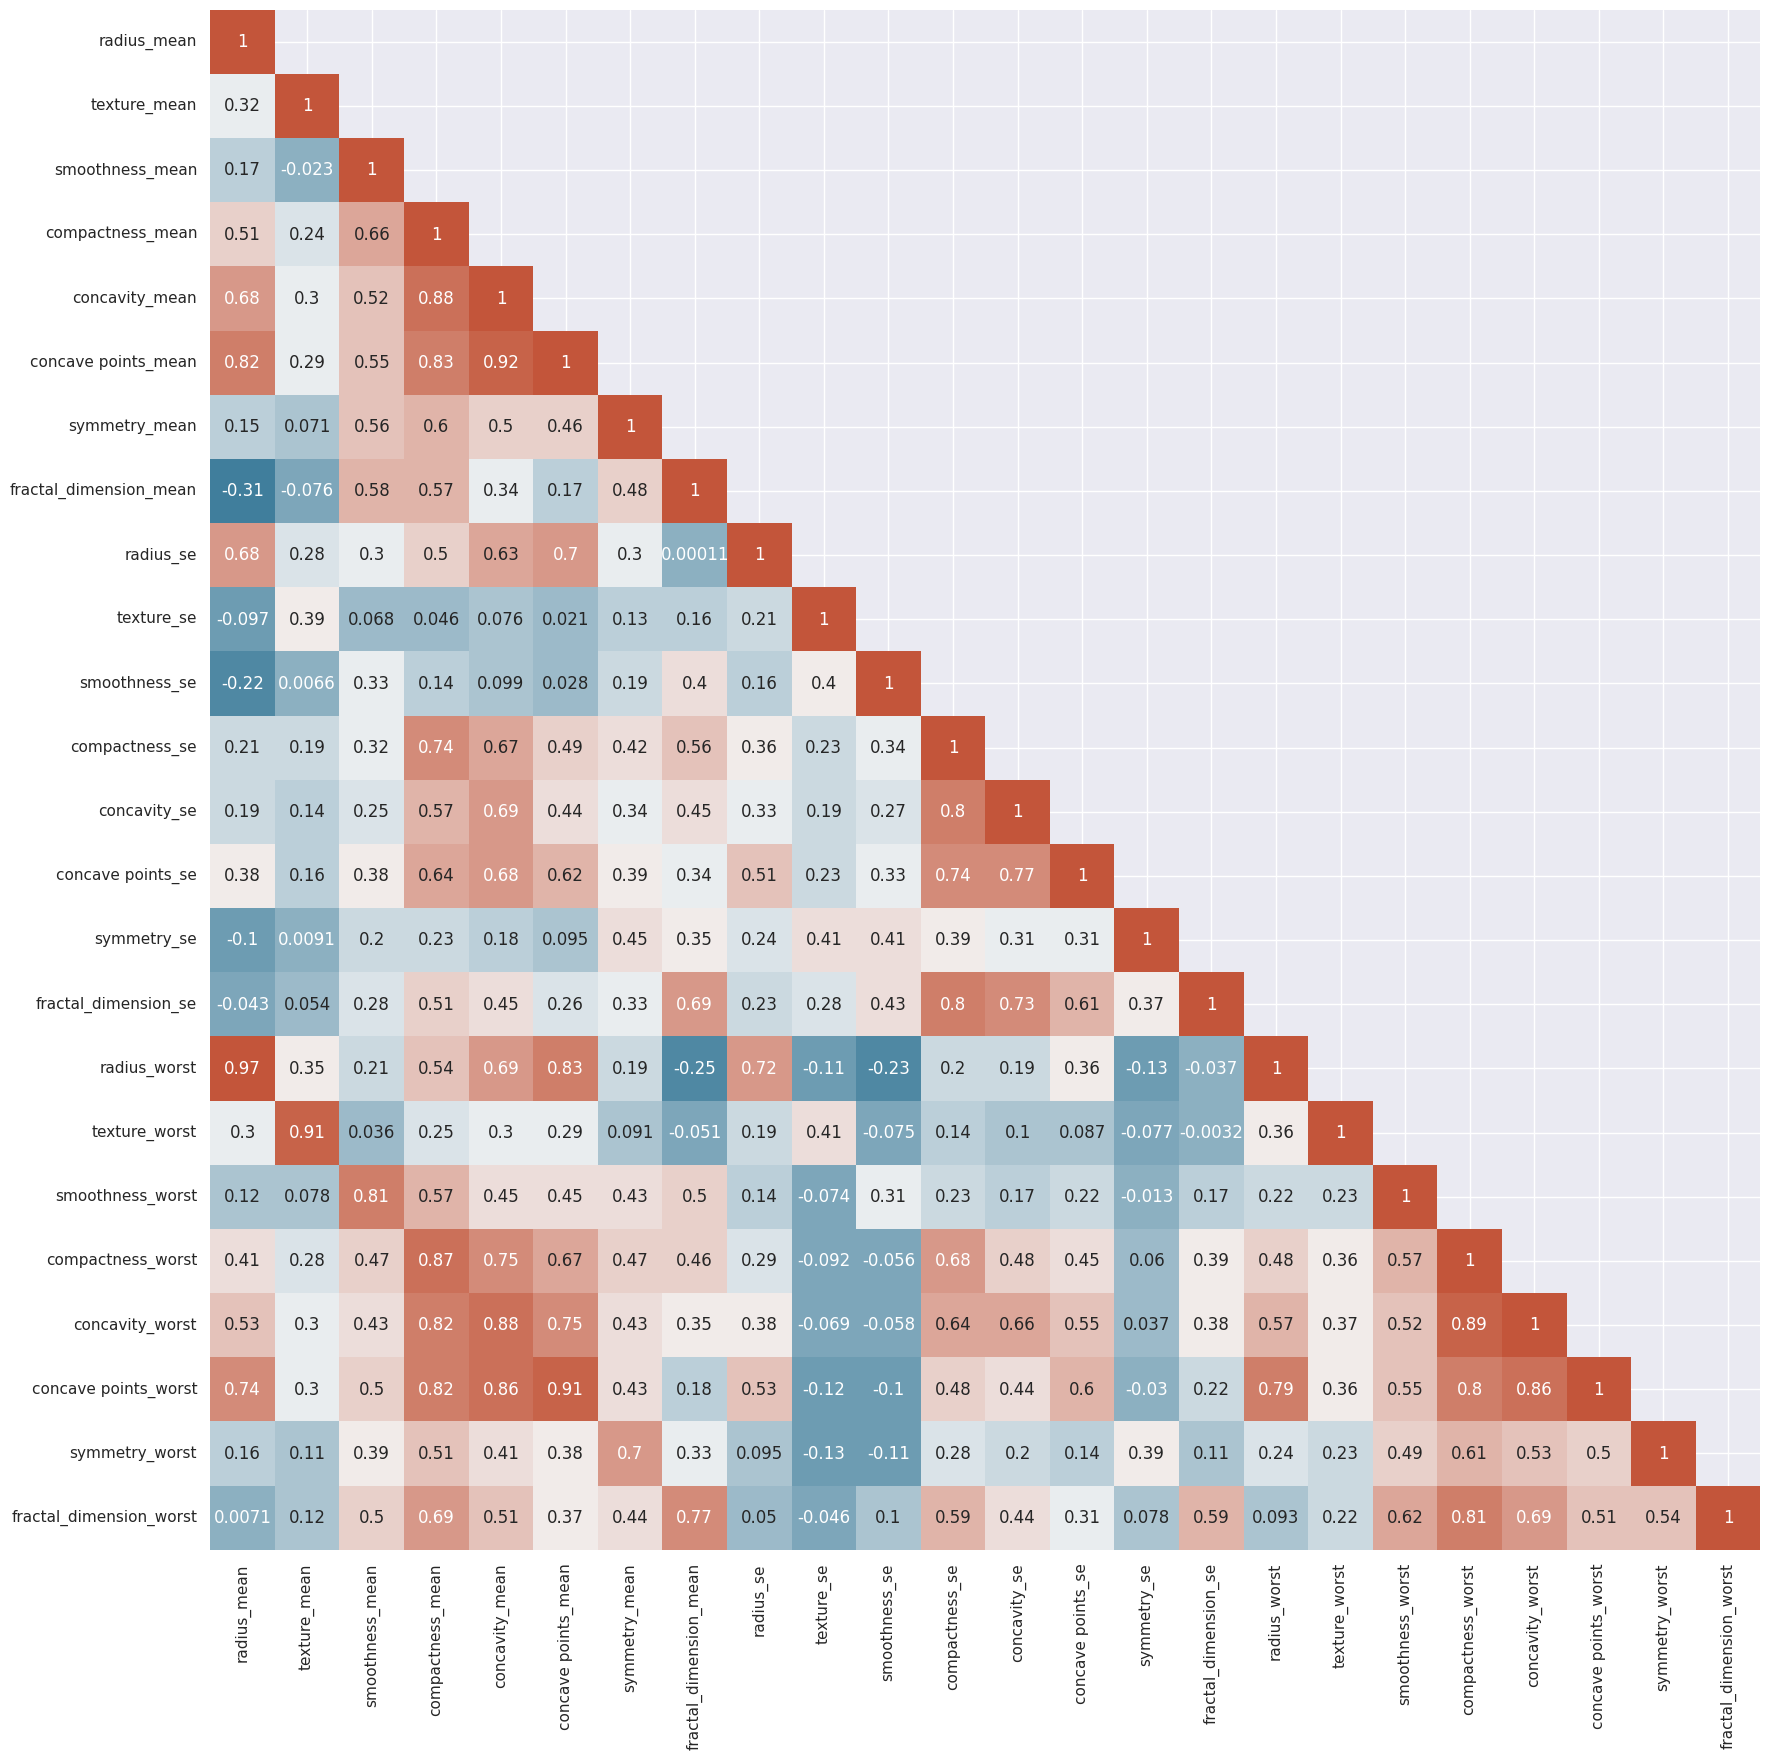

In [8]:
df_feats = df_feats.drop(
    [
        "perimeter_mean",
        "perimeter_se",
        "perimeter_worst",
        "area_mean",
        "area_se",
        "area_worst",
    ]
)
# Mask to remove superior correlation
corr_mask = df_feats.corr().to_numpy() - np.tril(df_feats.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(
    df_feats.to_pandas().corr(), annot=True, cbar=False, mask=corr_mask, cmap=CMAP
)
plt.show()

Now the correlations are looking better. Depending on the problem or the performance of the model, we could experiment by removing all the features that have a correlation higher or lower than an specified threshold: $-0.8<=t<=0.8$ could be a good example. We will not implement it here. 

Then we need to convert the targets to a numeric value. The targets are `M` for Malignant and `B` for Benign. We can substitute `B` for 0 and `M` for 1. We could do it the other way, but it will be useful for the perfomance metric later. 

In [9]:
df_target = df.select("diagnosis").with_columns(
    pl.when(pl.col("diagnosis") == "B").then(0).otherwise(1).alias("diagnosis")
)
# Get unique values
df_target.unique()

diagnosis
i32
1
0


The last step when loading the dataset is to rescale all the features. Different features have different scales, i.e., they have different maximum and minimum values. Machine learning algorithms normally do not perform well when working when the input features have different scales. Let's check how the values of the different features are distributed.

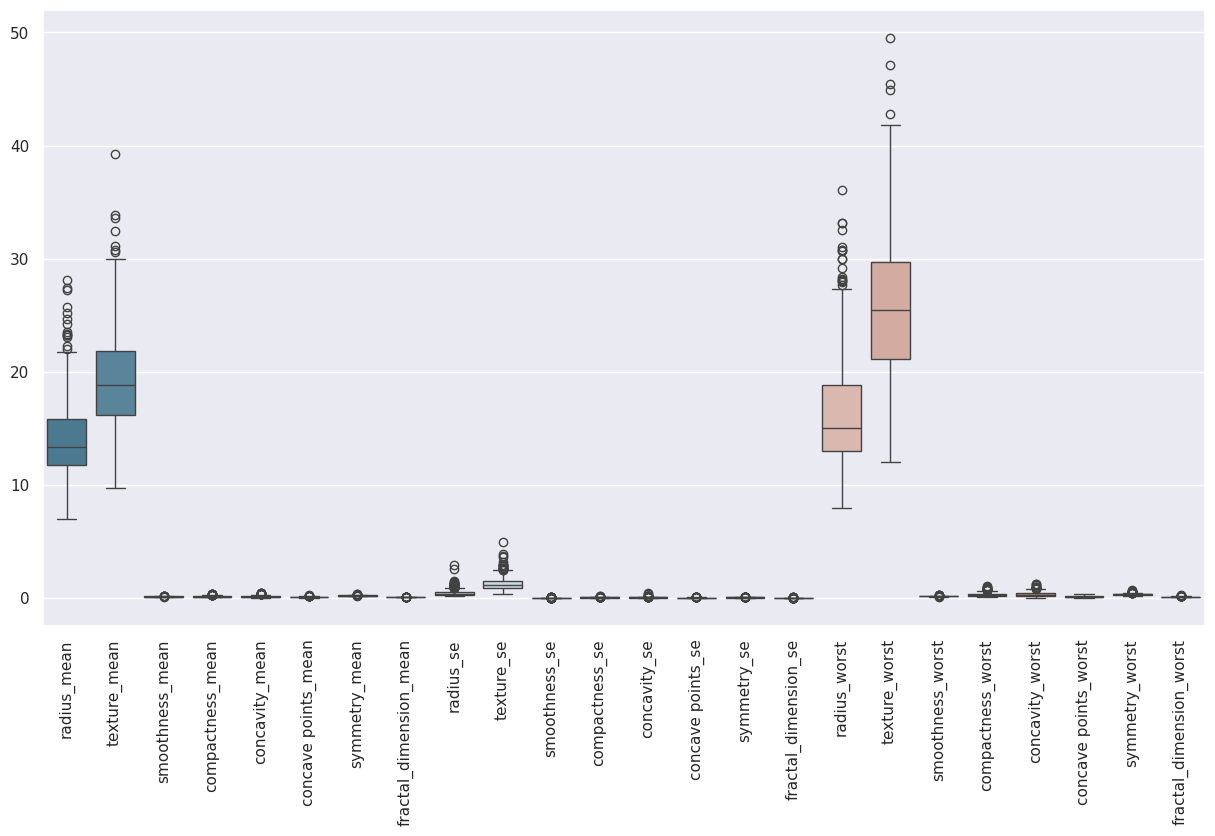

In [10]:
fig = plt.figure(figsize=(15, 8))
sns.boxplot(df_feats.to_pandas(), palette=CMAP)
plt.xticks(rotation="vertical")
plt.show()

As we can see on the previous boxplot, the scales vary a lot specially for the radius and texture features. Scikit-Learn provides some scalers that help us with this task. We will use the MinMaxScaler. 

This scaler calculates the standard deviation for every column, then rescales the values between zero and one. 

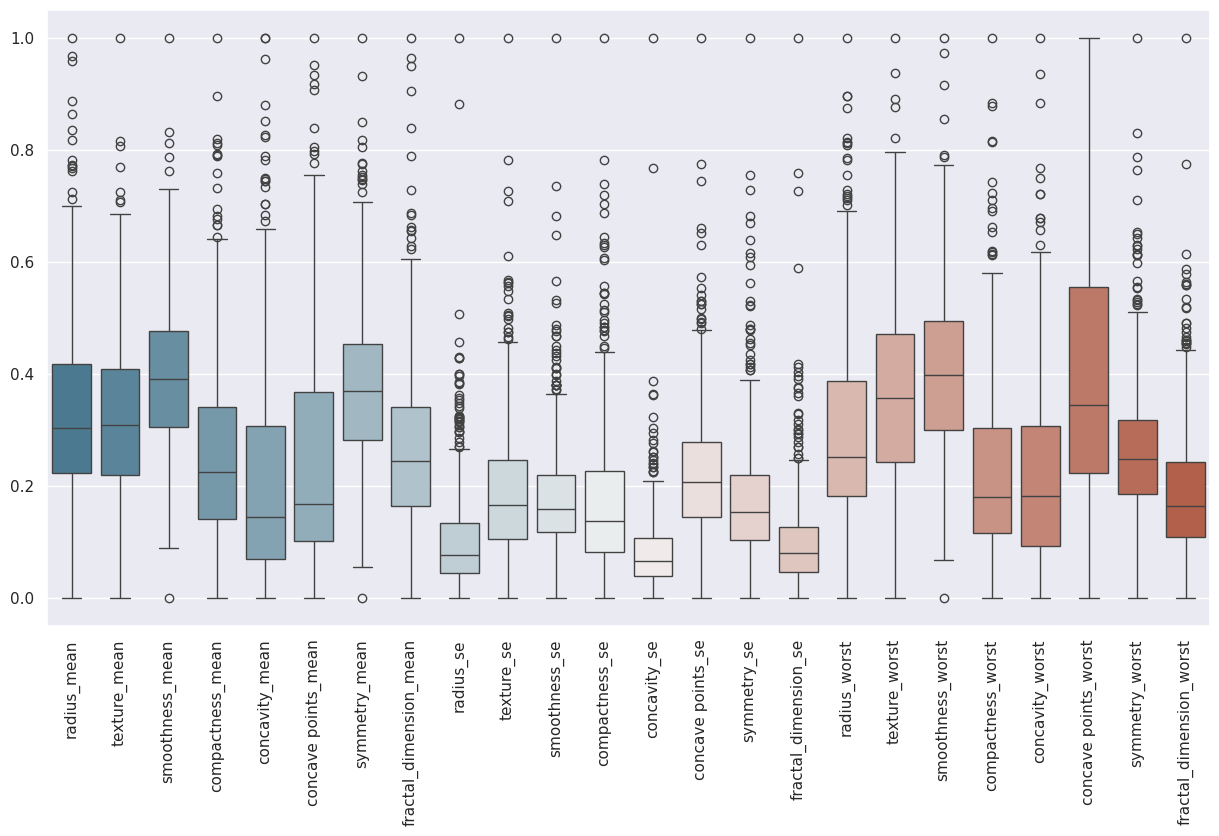

In [11]:
scaler = MinMaxScaler()
x = pl.from_numpy(scaler.fit_transform(df_feats), schema=df_feats.columns).to_pandas()
fig = plt.figure(figsize=(15, 8))
sns.boxplot(x, palette=CMAP)
plt.xticks(rotation="vertical")
plt.show()

As you can see in the image above, now all the features have the same scale, from zero to one. 

Finally, we can glue all together and create a function to load the dataset:

In [12]:
def load_data() -> Tuple[np.ndarray, np.ndarray]:
    df = (
        # Create the LazyFrame
        pl.scan_csv(DATASET_PATH)
        # Drop all unnecessary columns
        .drop(
            [
                "id",
                "",
                "perimeter_mean",
                "perimeter_se",
                "perimeter_worst",
                "area_mean",
                "area_se",
                "area_worst",
            ]
        ).with_columns(
            # Convert the target to a numeric value
            pl.col("diagnosis").replace({"B": 0, "M": 1}, return_dtype=pl.Int32),
        )
        # Convert to DataFrame
        .collect()
    )
    # Select X and Y
    x = df.drop("diagnosis").to_numpy()
    y = df.select("diagnosis").to_numpy()

    # Scale the x values
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y

## Working with Imbalanced Datasets

Most of the datasets we find in real life are not balanced, i.e., they do not have the same number of samples per class. It is important to know how many samples we have per class to determine the strategy to use to train the model and avoid overfitting the class with less samples. 

The strategy may vary from undersampling the rest of the classes to balance the number of samples per class, collecting more data (if possible), using different metrics to evaluate the model, oversampling the class with less examples, among others. 

The strategy depends on how many samples we have, and the difference of samples among classes. 

The `Breast Cancer` dataset contains only 2 classes and a total of `569` samples. Let's analyze how many samples we have per class:

/tmp/ipykernel_21155/3530116074.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="diagnosis", data=y_labels, palette=CMAP)
/tmp/ipykernel_21155/3530116074.py:12: UserWarning: The palette list has more values (24) than needed (2), which may not be intended.
  ax = sns.countplot(x="diagnosis", data=y_labels, palette=CMAP)


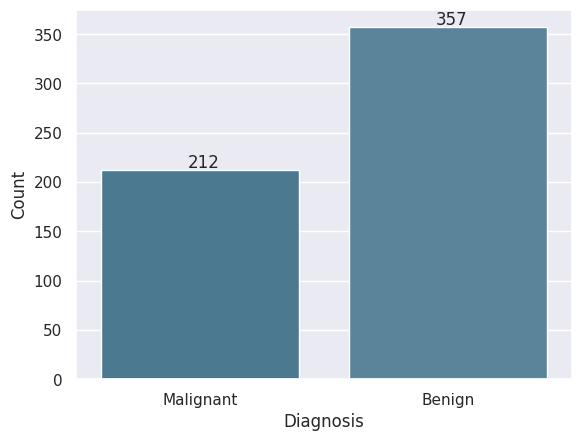

In [13]:
# Replace the labels on the target column
classes = {"M": "Malignant", "B": "Benign"}
y_labels = (
    # Select onlyf the target column
    df.select("diagnosis")
    # Replace the label letter by the full name
    .with_columns(pl.col("diagnosis").replace(classes))
    # Convert to pandas dataframe
    .to_pandas()
)
# Create the countplot
ax = sns.countplot(x="diagnosis", data=y_labels, palette=CMAP)
# Display the count values on top of the bars
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + 0.35, p.get_height() + 3))
# Change the name of the axis labels
plt.ylabel("Count")
plt.xlabel("Diagnosis")
plt.show()

We have more examples for the Bening class, with a ratio of $1.68:1$. This may cause the model to overfit the `Malignant` class. Due to the size of the dataset, undersampling may not be a good strategy, since we would lose $145$ rows, this is almost $25%$ of the dataset. 

What can we do then? Well, we can use other strategies:
- We can use other metrics to evaluate the model (more about this later)
- We can use an algorithm that work well with imbalanced datasets. Decision Trees work better with imbalanced datasets. We will use Random Forest for this problem. 
- Splitting data may be tricky to deal with. Since the classes have different number of samples, the probability of randomly selecting the "Benign" class for training is higher, increasing thus the imbalance when training. We need here a stratified sampling strategy. For this, we can use the cross-validator provided by Scikit-Learn that is `StratifiedShuffleSplit`

In [14]:
# Load the dataset
x, y = load_data()

# Split the dataset maintaining the proportion of the classes
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)
for train_idx, test_idx in splitter.split(x, y):
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

Let's evaluate the splitting of the sets by plotting the percentage of each class in the training and testing sets:

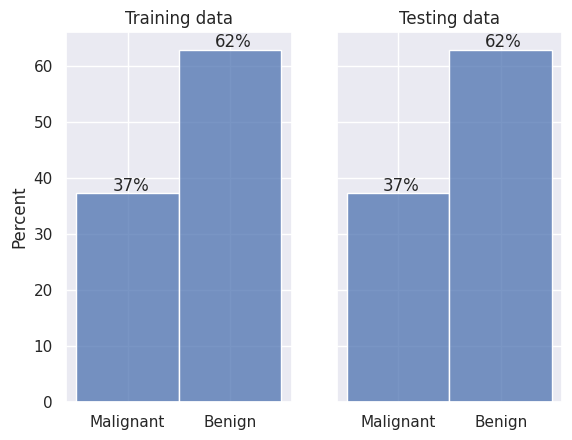

In [15]:
# Replace the numerical values of the classes for the labels
classes = {0: "Benign", 1: "Malignant"}
y_train_classes = [classes[idx] for idx in y_train.squeeze()]
y_test_classes = [classes[idx] for idx in y_test.squeeze()]

# Plot the percentages of each class in the splits
f, axs = plt.subplots(1, 2, sharey=True)

# Plot and annotate the training data classes histogram
sns.histplot(y_train_classes, stat="percent", ax=axs[0])
axs[0].set_title("Training data")
for p in axs[0].patches:
    axs[0].annotate(
        str(int(p.get_height())) + "%", (p.get_x() + 0.35, p.get_height() + 0.5)
    )

# Plot and annotate the testing data classes histogram
sns.histplot(y_train_classes, stat="percent", ax=axs[1])
axs[1].set_title("Testing data")
for p in axs[1].patches:
    axs[1].annotate(
        str(int(p.get_height())) + "%", (p.get_x() + 0.35, p.get_height() + 0.5)
    )

plt.ylabel("Percent")
plt.show()

In both cases the classes are represented by the proportion relative to the original dataset. We see that using `StratifiedShuffleSplit` to split the data allows us to maintain this proportions. 

Mainting this proportions will be useful when training the model, since we can specify the weights of each class to evaluate the performance of the model. 

## Model Training

As we mentioned before we will use the Random Forest as algorithm to make predictions. `RandomForest` is not a single model but an ensemble of models called `Decision Trees`.

![Random Forest](https://www.spotfire.com/content/dam/spotfire/images/graphics/inforgraphics/random-forest-diagram.svg)

>*Image n: Random Forest architecture. Image from Sportfire.*

`Random Forest` are composed of several `Decision Trees`. Each Tree makes a prediction and then the predictions are aggregated into a single prediction. The performance of the `Random Forest` is better than the performance of the best `Decision Tree` in the ensemble. 

`Random Forest` is one of the most powerful machine learning algorithms at the moment, but it still requires to be tuned. We will use Grid search to obtain the best hyperparameters for our algorithm. 

Scikit-Learn provides the optimizer `GridSearchCV` that allows us to set a list of parameters to try. The optimizer will evaluate the model on each possible combination of the hyperparameters and evaluate them on the target metric. After gitting the model, it provides the best parameters and the best estimator, i.e., the best Random Forest model.

However, what is the best metric to evaluate the model? 

As we see before, the dataset is imbalanced, therefore, accuracy is not a good metric. We can use the recall or precision. Recall measures the sensitivity of the model, that is, measures the proportion of actual positive cases that are correctly identified by the model. Precision on the other hand measures the proportion of positives predictions the model makes. 

There's a third option, that is F1 score, that is the harmonic mean of the precision and recall scores. Its formula is:
$$\text{F1 Score} = \frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}}=\frac{2TP}{2TP+FP+FN}$$

This is the metric that we will monitor when selecting the best estimator. Let's get the best model:

In [16]:
parameters = {
    # Number of Decision Trees in the ensemble
    "n_estimators": [100, 250, 500],
    # Function to measure the quality of a split at tree-level
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [6, 8, 10, 12],
}

random_forest_model = RandomForestClassifier()
clf = GridSearchCV(
    estimator=random_forest_model,
    param_grid=parameters,
    scoring="f1",
    cv=splitter,
    verbose=0,
    # Use all the cores available at the CPU
    n_jobs=-1,
)

In [17]:
clf.fit(x_train, y_train)

/home/alexapm/Dev/ml_platzi/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/alexapm/Dev/ml_platzi/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/alexapm/Dev/ml_platzi/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/alexapm/Dev/ml_platzi/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1, random_state=1992, test_size=0.3,
            train_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [6, 8, 10, 12],
                         'n_estimators': [100, 250, 500]},
             scoring='f1')

In [18]:
print(f"Best Estimator: {clf.best_estimator_}")
print(f"Best Parameters: {clf.best_params_}")

Best Estimator: RandomForestClassifier(max_depth=10, n_estimators=250)
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 250}


Now that we have the best estimator, we can now use the model to make predictions. But it is necessary to evaluate the model and see how good it performs. 

## Model Evaluation

The best way to evaluate the model is to make predictions on the test set to see how well it is predicting the target classes. We will display the Confusion Matrix to see how is predicting, and will print the `F1 Score`, `Recall` and `Precision` to measure the performance of the model. 

F1 Score:  0.9606
Recall:  0.9531
Precision:  0.9683


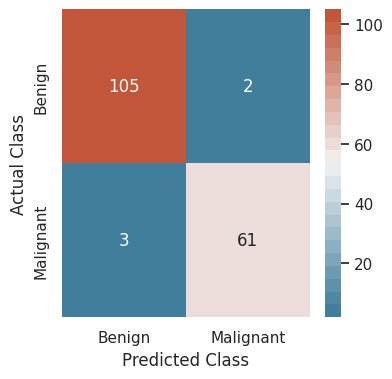

In [23]:
# Get the best estimator
model = clf.best_estimator_

# Get predictions for the test set
preds = model.predict(x_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds)
f1_evaluation = f1_score(y_true=y_test, y_pred=preds)
recall_evaluation = recall_score(y_true=y_test, y_pred=preds)
precision_evaluation = precision_score(y_true=y_test, y_pred=preds)

# Format the output of the confusion matrix
classes_ = list(classes.values())
# Convert the confusion matrix to a pandas dataframe
df_conf_matrix = pl.from_numpy(conf_matrix).to_pandas()
df_conf_matrix.columns = classes_
df_conf_matrix.index = classes_

# Display the results
print(f"F1 Score: {f1_evaluation: .4f}")
print(f"Recall: {recall_evaluation: .4f}")
print(f"Precision: {precision_evaluation: .4f}")

# Plot the confusion matrix
fig = plt.figure(figsize=(4, 4))
sns.heatmap(df_conf_matrix, annot=True, cmap=CMAP, fmt=".0f")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

The model is performing very well. There's only 3 malignant cases that were predicted as benign, this is only the $4.69%$ of the total cases. This is a very good result. This can be improved by training the model on a larger dataset, including more cases with malignant diagnosis.

## Conclusions

Training a model requires several previous steps to make sure we will obtain the best possible estimator with the data we have. We can include in these steps exploring the data, removing null values, feature selection, preprocessing the data, selecting the best model, selecting the best metric, among others. 

Even when applying all the possible steps, the model will never be perfect. It cannot be seen as a whole predictor, but as an important tool to help the medical team to take decisions. 

A further step would be to save the model and use it in production within an app.